In [1]:
import pandas as pd
from dataprep.eda import plot, plot_correlation
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from utils import *

NumExpr defaulting to 4 threads.


# Read Data

In [2]:
patient = pd.read_csv("mimic/PATIENTS.csv")
admission = pd.read_csv("mimic/ADMISSIONS.csv")
diagnoses_d = pd.read_csv("mimic/D_ICD_DIAGNOSES.csv")
diagnoses = pd.read_csv("mimic/DIAGNOSES_ICD.csv")
icu = pd.read_csv("mimic/ICUSTAYS.csv")
services = pd.read_csv('mimic/SERVICES.csv')

In [3]:
# Add Diagnoses group column
diagnoses['category'] = diagnoses['ICD9_CODE'].apply(lambda x: D_Category[assign_category(x)])
admission_patient = admission.merge(patient, on='SUBJECT_ID')
admission_patient['age'] = calculate_age(admission_patient, 'ADMITTIME', 'DOB')
admission_patient['LOS'] = (pd.to_datetime(admission_patient['DISCHTIME']) - pd.to_datetime(admission_patient['ADMITTIME'])).dt.total_seconds()/86400
admission_patient = admission_patient[admission_patient['age']>=15]
admission_patient = admission_patient[admission_patient['LOS']>0]
adm_icu_p = admission_patient.merge(icu.drop('LOS', axis=1), on='HADM_ID')
adm_icu_p = adm_icu_p[['HADM_ID', 'age', 'GENDER', 'LOS', 'ADMISSION_TYPE', 'DIAGNOSIS', 'FIRST_CAREUNIT', 'HOSPITAL_EXPIRE_FLAG', 'INSURANCE']]

adm_icu_p

,HADM_ID,age,GENDER,LOS,ADMISSION_TYPE,DIAGNOSIS,FIRST_CAREUNIT,HOSPITAL_EXPIRE_FLAG,INSURANCE
0,165315,65,F,1.144444,EMERGENCY,BENZODIAZEPINE OVERDOSE,MICU,0,Private
1,152223,71,M,5.496528,ELECTIVE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,CSRU,0,Medicare
2,124321,75,M,6.768056,EMERGENCY,BRAIN MASS,SICU,0,Medicare
3,161859,39,M,2.856944,EMERGENCY,INTERIOR MYOCARDIAL INFARCTION,CCU,0,Private
4,129635,59,M,3.534028,EMERGENCY,ACUTE CORONARY SYNDROME,CCU,0,Private
...,...,...,...,...,...,...,...,...,...
53352,190603,78,M,4.145833,ELECTIVE,AORTIC STENOSIS\AORTIC VALVE REPLACEMENT /SDA,CSRU,0,Medicare
53353,105447,88,M,0.662500,EMERGENCY,ALTERED MENTAL STATUS,MICU,1,Medicare
53354,191113,20,F,2.742361,EMERGENCY,TRAUMA,TSICU,0,Private
53355,101071,84,F,0.548611,EMERGENCY,SAH,MICU,1,Medicare


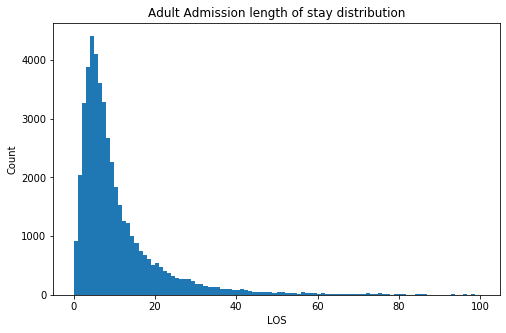

In [34]:

plt.hist(adm_icu_p[adm_icu_p['LOS']<=100]['LOS'], bins=100)
plt.xlabel('LOS')
plt.ylabel('Count')
plt.title('Adult Admission length of stay distribution')
plt.savefig('plots/dist.png')

# 1. Age & Gender

In [16]:
plot(adm_icu_p[['age']])
plot(adm_icu_p[['GENDER']])

GridBox(id='1307', ...)

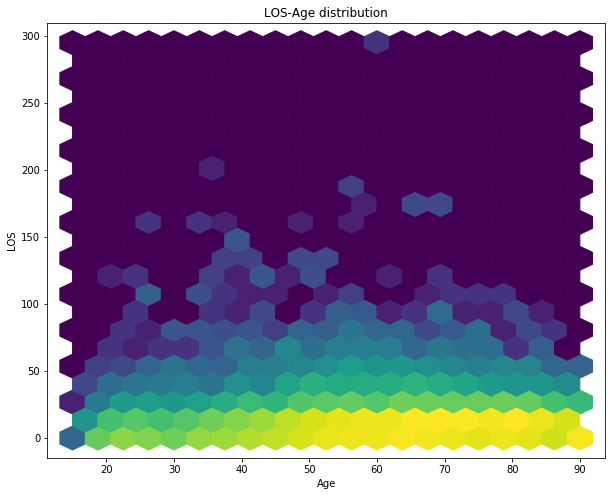

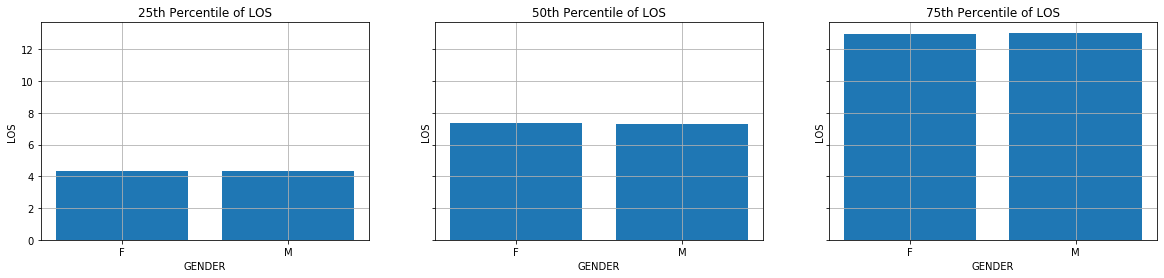

In [17]:
# Age - LOS
f1, ax1 = plt.subplots(figsize=(10, 8))
hb1 = plt.hexbin(adm_icu_p['age'], adm_icu_p['LOS'], gridsize=20, bins='log')
ax1.set(xlabel='Age', ylabel='LOS')
ax1.set_title('LOS-Age distribution');

# Gender(Adult) - LOS
adults = adm_icu_p[adm_icu_p['age']>=15]
p25 = adults.groupby('GENDER')['LOS'].quantile(0.25).reset_index(name='25TH_LOS')
p50 = adults.groupby('GENDER')['LOS'].quantile(0.5).reset_index(name='50TH_LOS')
p75 = adults.groupby('GENDER')['LOS'].quantile(0.75).reset_index(name='75TH_LOS')
dfcor = p25.merge(p50, on='GENDER', how='left')
dfcor = dfcor.merge(p75, on='GENDER', how='left')
fig, (ax01, ax02, ax03) = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
ax01.grid()
ax02.grid()
ax03.grid()
ax01.set(xlabel='GENDER', ylabel='LOS', title='25th Percentile of LOS')
ax02.set(xlabel='GENDER', ylabel='LOS', title='50th Percentile of LOS')
ax03.set(xlabel='GENDER', ylabel='LOS', title='75th Percentile of LOS')
ax01.bar(dfcor['GENDER'], dfcor['25TH_LOS'])
ax02.bar(dfcor['GENDER'], dfcor['50TH_LOS'])
ax03.bar(dfcor['GENDER'], dfcor['75TH_LOS']);

# 2. Admission Type

In [18]:
plot(adm_icu_p[['ADMISSION_TYPE']])

GridBox(id='1408', ...)

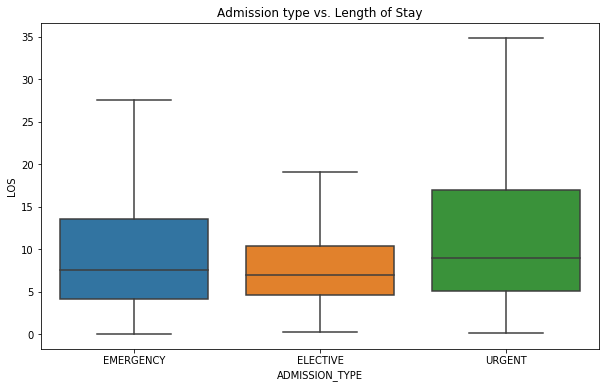

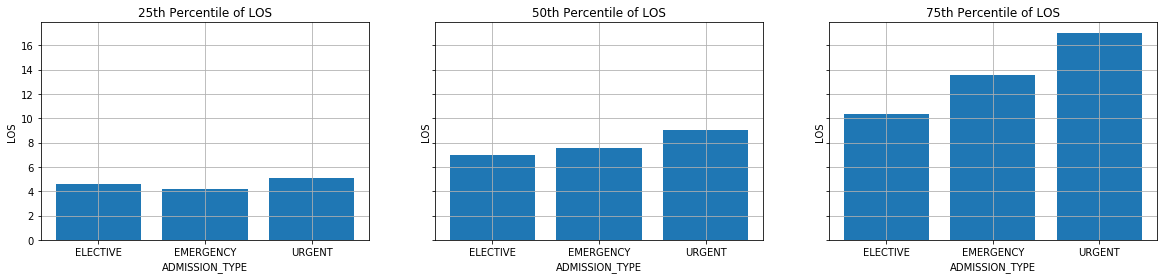

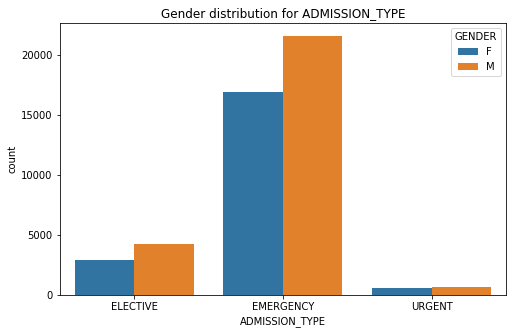

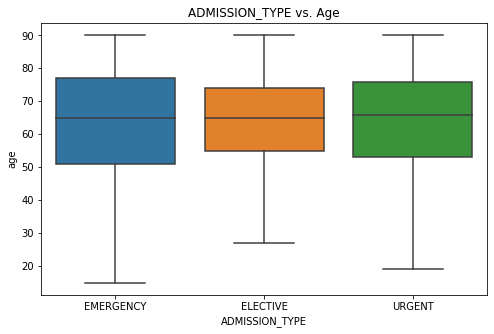

In [36]:
fig, ax = plt.subplots()
ax = sns.boxplot(x='ADMISSION_TYPE', y='LOS', data=adm_icu_p, showfliers=False)
ax.set_title('Admission type vs. Length of Stay')
fig.set_size_inches(10, 6, forward=True)
p25 = adm_icu_p.groupby('ADMISSION_TYPE')['LOS'].quantile(0.25).reset_index(name='25TH_LOS')
p50 = adm_icu_p.groupby('ADMISSION_TYPE')['LOS'].quantile(0.5).reset_index(name='50TH_LOS')
p75 = adm_icu_p.groupby('ADMISSION_TYPE')['LOS'].quantile(0.75).reset_index(name='75TH_LOS')
dfcor = p25.merge(p50, on='ADMISSION_TYPE', how='left')
dfcor = dfcor.merge(p75, on='ADMISSION_TYPE', how='left')
fig, (ax01, ax02, ax03) = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
ax01.grid()
ax02.grid()
ax03.grid()
ax01.set(xlabel='ADMISSION_TYPE', ylabel='LOS', title='25th Percentile of LOS')
ax02.set(xlabel='ADMISSION_TYPE', ylabel='LOS', title='50th Percentile of LOS')
ax03.set(xlabel='ADMISSION_TYPE', ylabel='LOS', title='75th Percentile of LOS')
ax01.bar(dfcor['ADMISSION_TYPE'], dfcor['25TH_LOS'])
ax02.bar(dfcor['ADMISSION_TYPE'], dfcor['50TH_LOS'])
ax03.bar(dfcor['ADMISSION_TYPE'], dfcor['75TH_LOS']);


# Adm_type - Gender
fig1, ax1 = plt.subplots()
data = adm_icu_p.groupby(['ADMISSION_TYPE', 'GENDER']).size().rename('count').reset_index()
ax1 = sns.barplot(x='ADMISSION_TYPE', y='count', hue='GENDER', data=data)
ax1.set_title('Gender distribution for ADMISSION_TYPE');
# Adm_type - Age
fig2, ax2 = plt.subplots()
ax2 = sns.boxplot(x='ADMISSION_TYPE', y='age', data=adm_icu_p, showfliers=False)
ax2.set_title('ADMISSION_TYPE vs. Age')

plt.show();



# 3. ICU Type

In [20]:
# ICU first admission analysis
icu['INTIME'] = pd.to_datetime(icu['INTIME'])
icu_first = icu.groupby('SUBJECT_ID').agg({'INTIME':'min'})
icu_first = icu.merge(icu_first, on=['SUBJECT_ID', 'INTIME'])

# overall ICU type hist
plot(icu[['FIRST_CAREUNIT']])
# first adm ICU type hist
# plot(icu_first[['FIRST_CAREUNIT']])

GridBox(id='1515', ...)

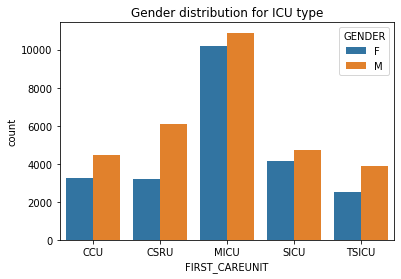

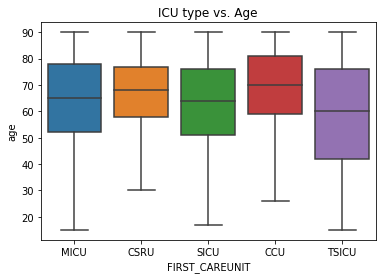

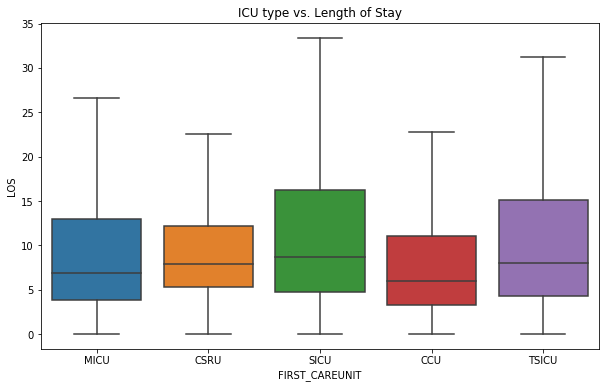

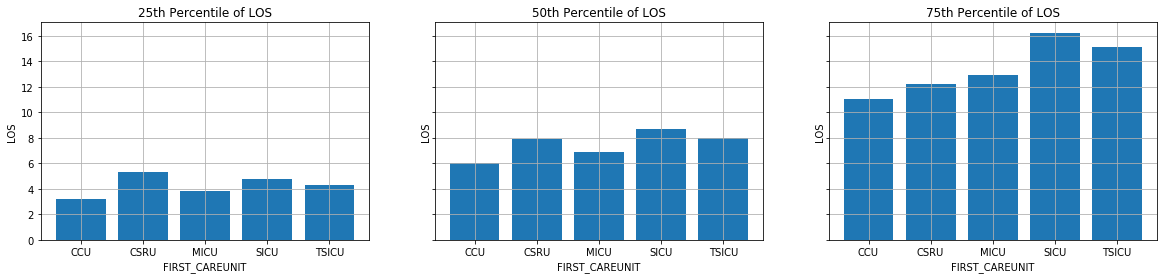

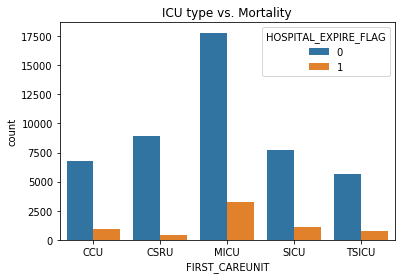

In [4]:
# icu_adm_p = icu_first.merge(admission_patient, on='SUBJECT_ID')

# ICU type vs Gender
fig1, ax1 = plt.subplots()
data = adm_icu_p.groupby(['FIRST_CAREUNIT', 'GENDER']).size().rename('count').reset_index()
ax1 = sns.barplot(x='FIRST_CAREUNIT', y='count', hue='GENDER', data=data)
ax1.set_title('Gender distribution for ICU type')
# ICU type vs age
fig2, ax2 = plt.subplots()
ax2 = sns.boxplot(x='FIRST_CAREUNIT', y='age', data=adm_icu_p, showfliers=False)
ax2.set_title('ICU type vs. Age')
# ICU type vs LOS
fig3, ax3 = plt.subplots()
ax3 = sns.boxplot(x='FIRST_CAREUNIT', y='LOS', data=adm_icu_p, showfliers=False)
ax3.set_title('ICU type vs. Length of Stay')
fig3.set_size_inches(10, 6, forward=True)

# icu_type = icu_adm_p.groupby('FIRST_CAREUNIT')['LOS']..quantile(0.25).reset_index(name='25TH_HOUSE_PRICE')
p25 = adm_icu_p.groupby('FIRST_CAREUNIT')['LOS'].quantile(0.25).reset_index(name='25TH_LOS')
p50 = adm_icu_p.groupby('FIRST_CAREUNIT')['LOS'].quantile(0.5).reset_index(name='50TH_LOS')
p75 = adm_icu_p.groupby('FIRST_CAREUNIT')['LOS'].quantile(0.75).reset_index(name='75TH_LOS')
dfcor = p25.merge(p50, on='FIRST_CAREUNIT', how='left')
dfcor = dfcor.merge(p75, on='FIRST_CAREUNIT', how='left')
fig, (ax01, ax02, ax03) = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
ax01.grid()
ax02.grid()
ax03.grid()
ax01.set(xlabel='FIRST_CAREUNIT', ylabel='LOS', title='25th Percentile of LOS')
ax02.set(xlabel='FIRST_CAREUNIT', ylabel='LOS', title='50th Percentile of LOS')
ax03.set(xlabel='FIRST_CAREUNIT', ylabel='LOS', title='75th Percentile of LOS')
ax01.bar(dfcor['FIRST_CAREUNIT'], dfcor['25TH_LOS'])
ax02.bar(dfcor['FIRST_CAREUNIT'], dfcor['50TH_LOS'])
ax03.bar(dfcor['FIRST_CAREUNIT'], dfcor['75TH_LOS']);

# ICU type vs Mortality
fig4, ax4 = plt.subplots()
data2 = adm_icu_p.groupby(['FIRST_CAREUNIT', 'HOSPITAL_EXPIRE_FLAG']).size().rename('count').reset_index()
ax4 = sns.barplot(x='FIRST_CAREUNIT', y='count', hue='HOSPITAL_EXPIRE_FLAG', data=data2)
ax4.set_title('ICU type vs. Mortality')

plt.show();

# 4. Diagnosis

In [22]:
plot(adm_icu_p[['DIAGNOSIS']])

GridBox(id='1628', ...)

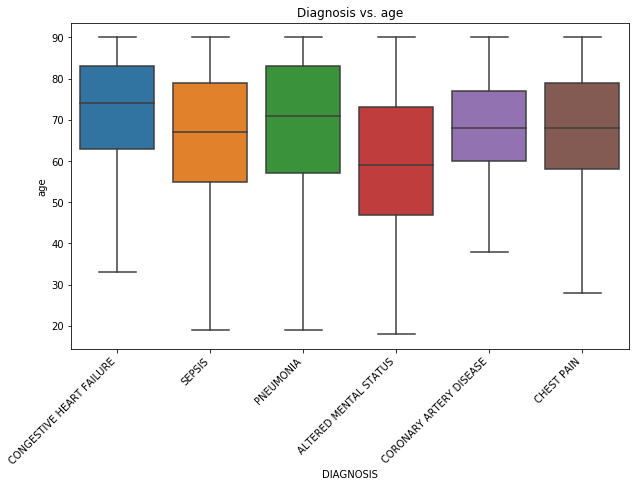

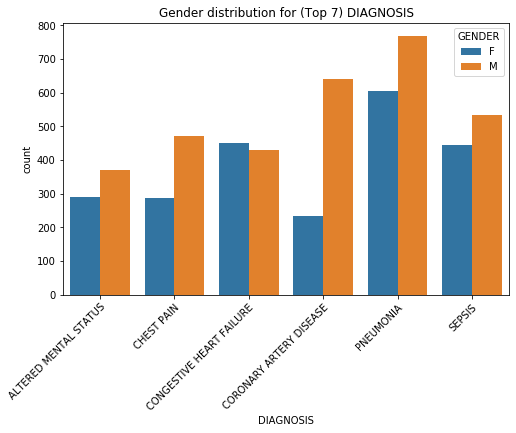

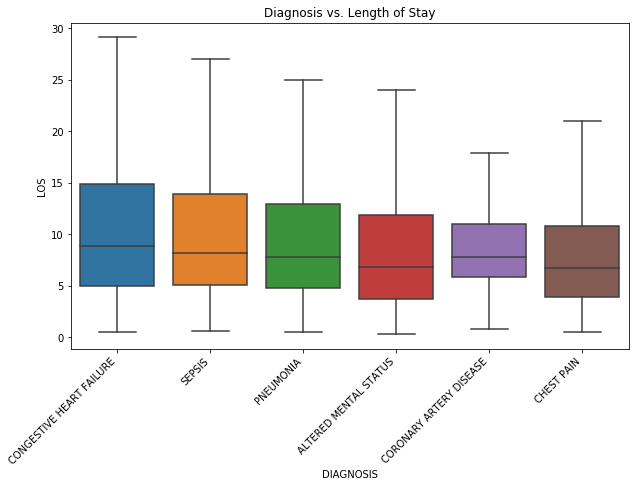

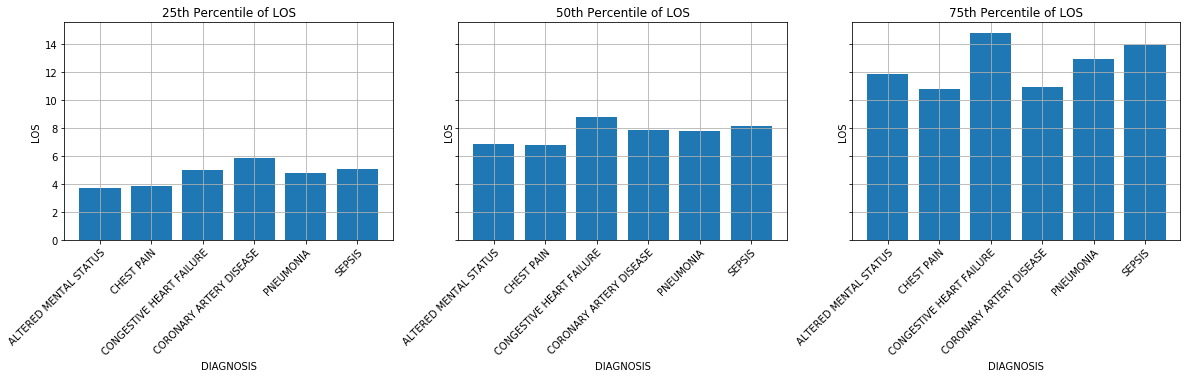

In [40]:
# Top 7
top_7 = ['NEWBORN', 'PNEUMONIA', 'SEPSIS', 'CONGESTIVE HEART FAILURE', 'CORONARY ARTERY DISEASE', 'CHEST PAIN', 'ALTERED MENTAL STATUS']
top_diag = adm_icu_p
top_diag['flag'] = top_diag['DIAGNOSIS'].apply(lambda x: 1 if (x in top_7) else 0)
top_diag = top_diag[top_diag['flag']==1]
# Diag - Age
fig1, ax1 = plt.subplots()
ax1 = sns.boxplot(x='DIAGNOSIS', y='age', data=top_diag, showfliers=False)
ax1.set_title('Diagnosis vs. age')
fig1.set_size_inches(10, 6, forward=True)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right');

# Diag - gender
fig2, ax2 = plt.subplots()
data = top_diag.groupby(['DIAGNOSIS', 'GENDER']).size().rename('count').reset_index()
ax2 = sns.barplot(x='DIAGNOSIS', y='count', hue='GENDER', data=data)
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax2.set_title('Gender distribution for (Top 7) DIAGNOSIS');

# Diag - LOS
fig, ax = plt.subplots()
ax = sns.boxplot(x='DIAGNOSIS', y='LOS', data=top_diag, showfliers=False)
ax.set_title('Diagnosis vs. Length of Stay')
fig.set_size_inches(10, 6, forward=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

p25 = top_diag.groupby('DIAGNOSIS')['LOS'].quantile(0.25).reset_index(name='25TH_LOS')
p50 = top_diag.groupby('DIAGNOSIS')['LOS'].quantile(0.5).reset_index(name='50TH_LOS')
p75 = top_diag.groupby('DIAGNOSIS')['LOS'].quantile(0.75).reset_index(name='75TH_LOS')
dfcor = p25.merge(p50, on='DIAGNOSIS', how='left')
dfcor = dfcor.merge(p75, on='DIAGNOSIS', how='left')
fig3, (ax01, ax02, ax03) = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
ax01.grid()
ax02.grid()
ax03.grid()
plt.setp(ax01.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.setp(ax02.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.setp(ax03.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax01.set(xlabel='DIAGNOSIS', ylabel='LOS', title='25th Percentile of LOS')
ax02.set(xlabel='DIAGNOSIS', ylabel='LOS', title='50th Percentile of LOS')
ax03.set(xlabel='DIAGNOSIS', ylabel='LOS', title='75th Percentile of LOS')
ax01.bar(dfcor['DIAGNOSIS'], dfcor['25TH_LOS'])
ax02.bar(dfcor['DIAGNOSIS'], dfcor['50TH_LOS'])
ax03.bar(dfcor['DIAGNOSIS'], dfcor['75TH_LOS'])

plt.show();

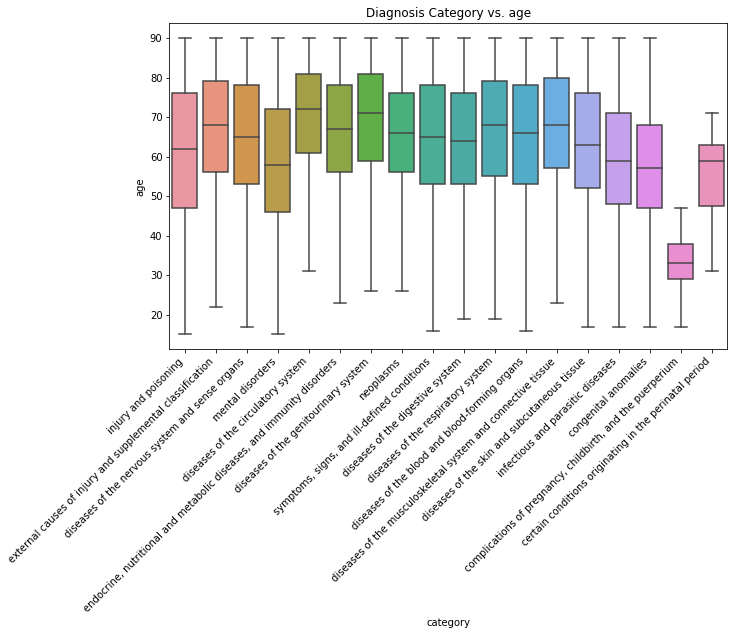

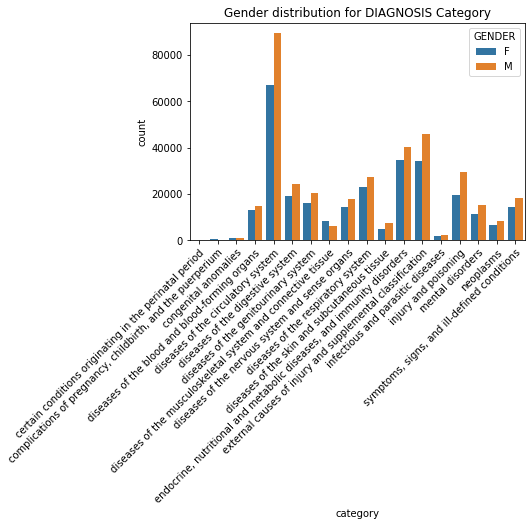

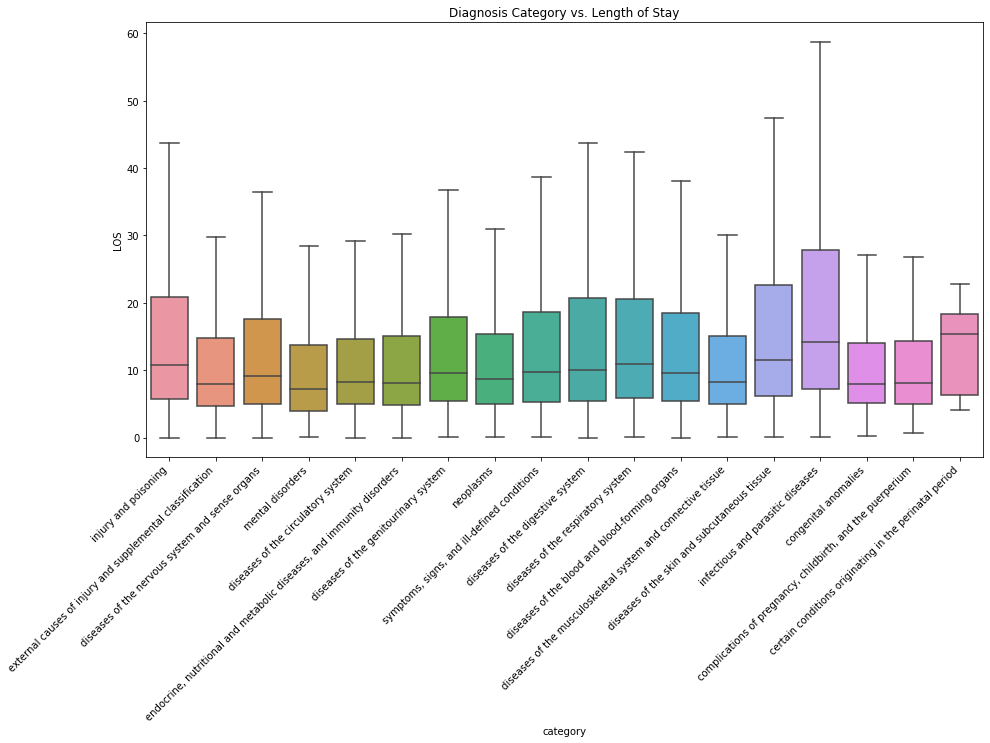

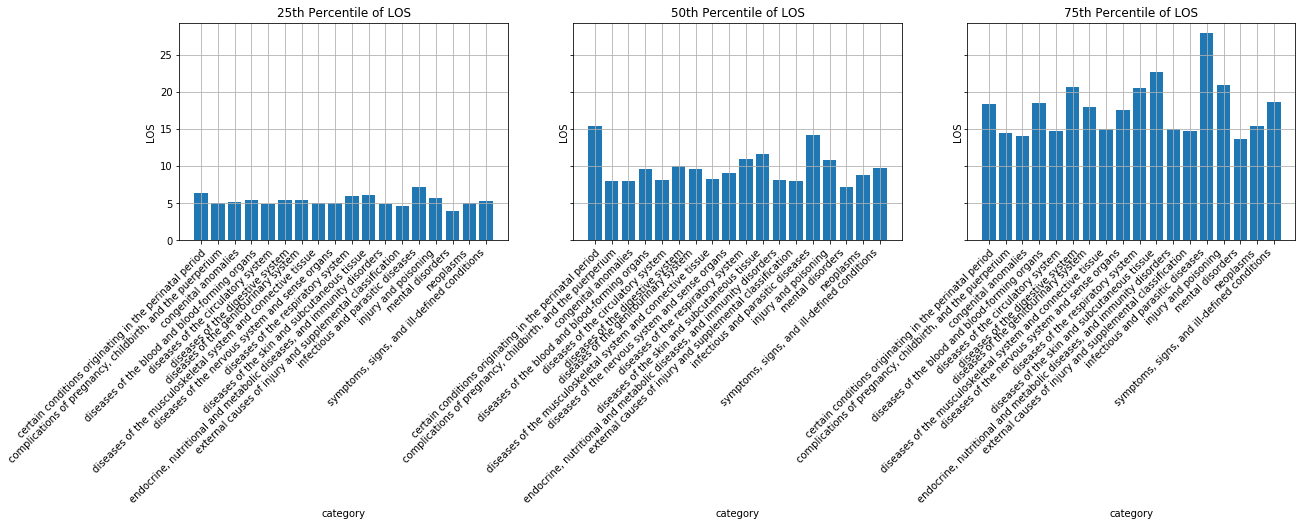

In [5]:
# Diag-Group
adm_icu_p_d = adm_icu_p.merge(diagnoses, on='HADM_ID')

# Diag Group - Age
fig1, ax1 = plt.subplots()
ax1 = sns.boxplot(x='category', y='age', data=adm_icu_p_d, showfliers=False)
ax1.set_title('Diagnosis Category vs. age')
fig1.set_size_inches(10, 6, forward=True)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right');

# Diag Group - gender
fig2, ax2 = plt.subplots()
data = adm_icu_p_d.groupby(['category', 'GENDER']).size().rename('count').reset_index()
ax2 = sns.barplot(x='category', y='count', hue='GENDER', data=data)
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax2.set_title('Gender distribution for DIAGNOSIS Category');

# Diag Group - LOS
fig3, ax3 = plt.subplots()
ax3 = sns.boxplot(x='category', y='LOS', data=adm_icu_p_d, showfliers=False)
ax3.set_title('Diagnosis Category vs. Length of Stay')
fig3.set_size_inches(15, 8, forward=True)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, horizontalalignment='right');
fig3.savefig('LOS-diagnosis.png')

p25 = adm_icu_p_d.groupby('category')['LOS'].quantile(0.25).reset_index(name='25TH_LOS')
p50 = adm_icu_p_d.groupby('category')['LOS'].quantile(0.5).reset_index(name='50TH_LOS')
p75 = adm_icu_p_d.groupby('category')['LOS'].quantile(0.75).reset_index(name='75TH_LOS')
dfcor = p25.merge(p50, on='category', how='left')
dfcor = dfcor.merge(p75, on='category', how='left')
fig, (ax01, ax02, ax03) = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
ax01.grid()
ax02.grid()
ax03.grid()
plt.setp(ax01.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.setp(ax02.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.setp(ax03.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax01.set(xlabel='category', ylabel='LOS', title='25th Percentile of LOS')
ax02.set(xlabel='category', ylabel='LOS', title='50th Percentile of LOS')
ax03.set(xlabel='category', ylabel='LOS', title='75th Percentile of LOS')
ax01.bar(dfcor['category'], dfcor['25TH_LOS'])
ax02.bar(dfcor['category'], dfcor['50TH_LOS'])
ax03.bar(dfcor['category'], dfcor['75TH_LOS'])

plt.show();

# 5. Service Type

In [27]:
# Service Type
service_icu = services.merge(adm_icu_p, on='HADM_ID')
plot(service_icu[['CURR_SERVICE']])


GridBox(id='1747', ...)

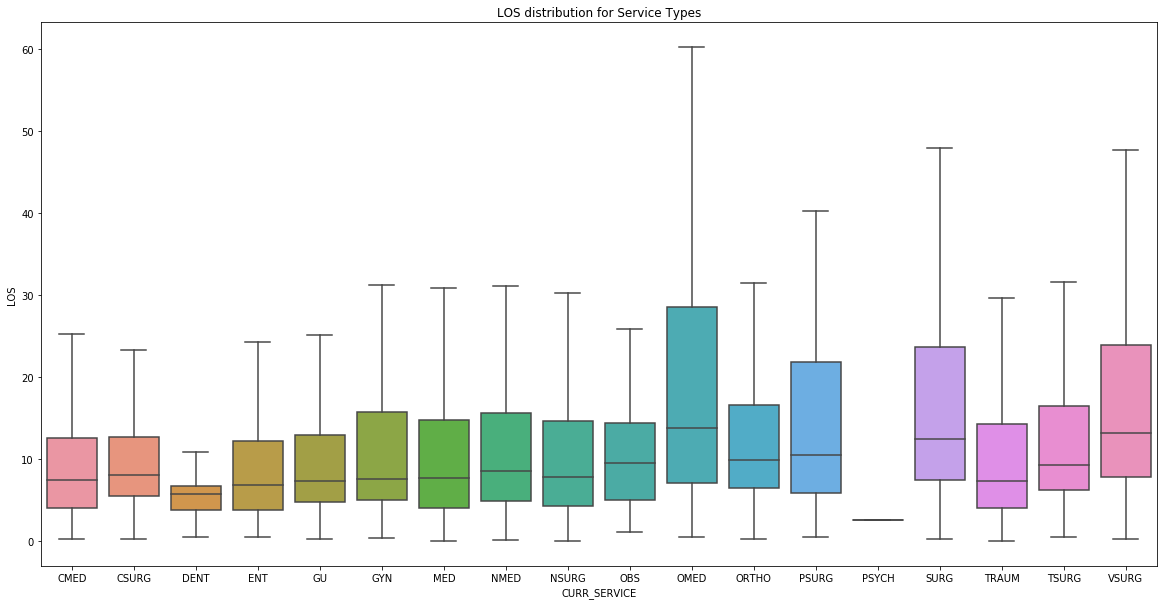

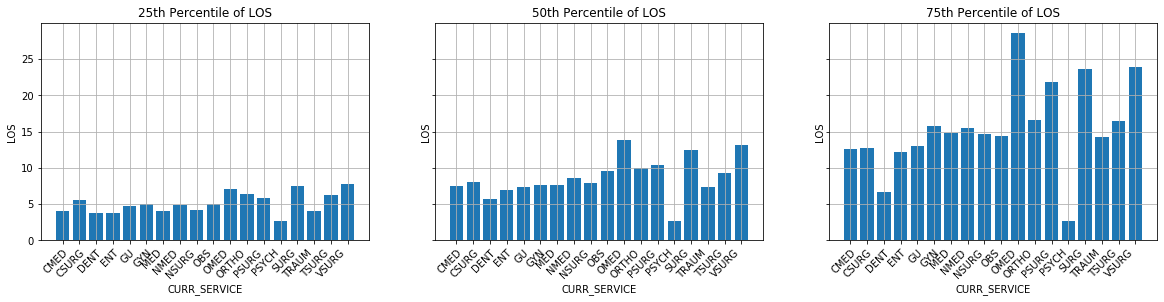

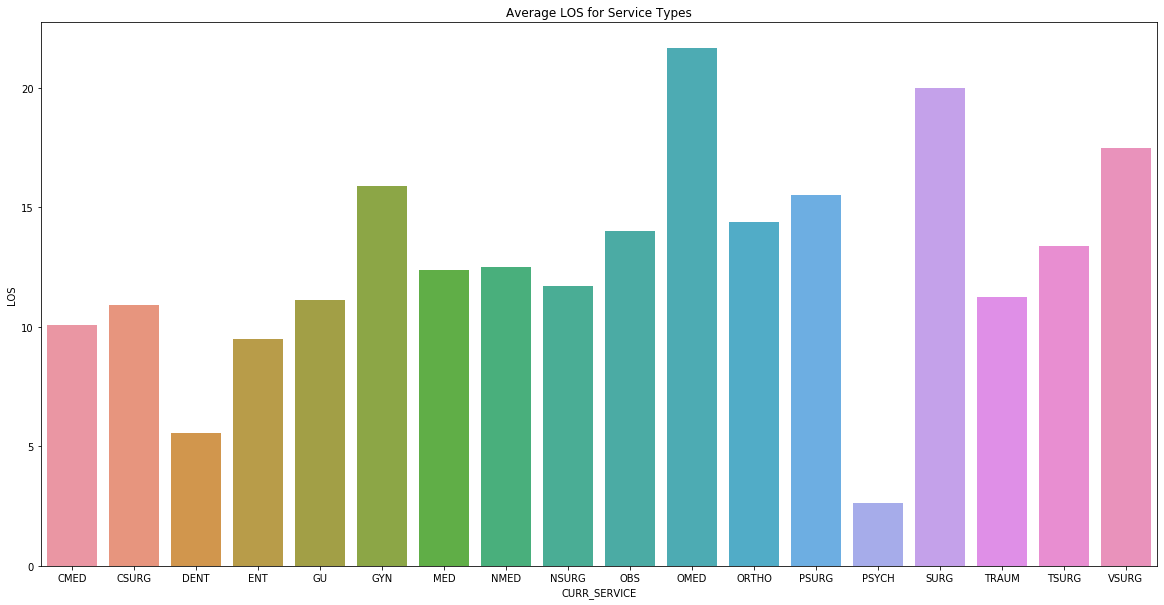

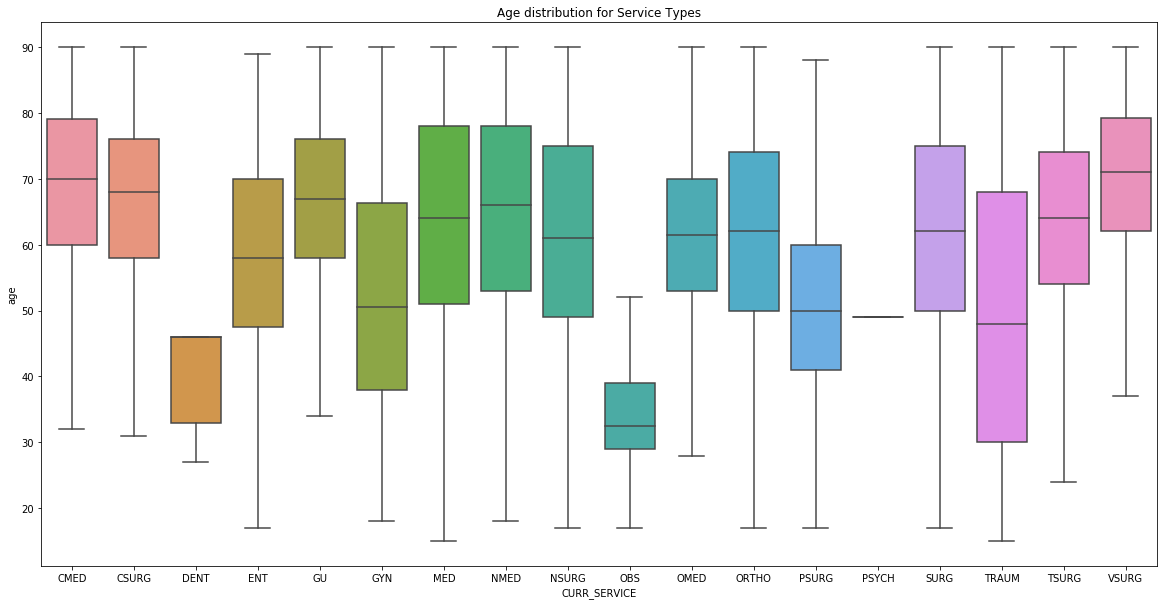

In [42]:
# Service - LOS
f1, ax1 = plt.subplots(figsize=(20, 10))
ax1 = sns.boxplot(x="CURR_SERVICE", y="LOS", data=service_icu.sort_values(by='CURR_SERVICE'), showfliers=False)
ax1.set_title('LOS distribution for Service Types');

p25 = service_icu.groupby('CURR_SERVICE')['LOS'].quantile(0.25).reset_index(name='25TH_LOS')
p50 = service_icu.groupby('CURR_SERVICE')['LOS'].quantile(0.5).reset_index(name='50TH_LOS')
p75 = service_icu.groupby('CURR_SERVICE')['LOS'].quantile(0.75).reset_index(name='75TH_LOS')
dfcor = p25.merge(p50, on='CURR_SERVICE', how='left')
dfcor = dfcor.merge(p75, on='CURR_SERVICE', how='left')
fig, (ax01, ax02, ax03) = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
plt.setp(ax01.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.setp(ax02.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.setp(ax03.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax01.grid()
ax02.grid()
ax03.grid()
ax01.set(xlabel='CURR_SERVICE', ylabel='LOS', title='25th Percentile of LOS')
ax02.set(xlabel='CURR_SERVICE', ylabel='LOS', title='50th Percentile of LOS')
ax03.set(xlabel='CURR_SERVICE', ylabel='LOS', title='75th Percentile of LOS')
ax01.bar(dfcor['CURR_SERVICE'], dfcor['25TH_LOS'])
ax02.bar(dfcor['CURR_SERVICE'], dfcor['50TH_LOS'])
ax03.bar(dfcor['CURR_SERVICE'], dfcor['75TH_LOS']);

f2, ax2 = plt.subplots(figsize=(20, 10))
serv_icu_g = service_icu.groupby('CURR_SERVICE')['LOS'].mean().reset_index()
ax2 = sns.barplot(x='CURR_SERVICE', y='LOS', data=serv_icu_g.sort_values(by='CURR_SERVICE'))
ax2.set_title('Average LOS for Service Types');

# Service - Age
# icu_p = icu.merge(patient, on='SUBJECT_ID')
# icu_p['age'] = calculate_age(icu_p, 'INTIME', 'DOB')
# icu_age = icu_p[['HADM_ID', 'age']]
# service_icu = service_icu.merge(icu_age, on='HADM_ID')
f3, ax3 = plt.subplots(figsize=(20, 10))
ax3 = sns.boxplot(x="CURR_SERVICE", y="age", data=service_icu.sort_values(by='CURR_SERVICE'), showfliers=False)
ax3.set_title('Age distribution for Service Types')

plt.show();

# Insurance Type

In [7]:
plot(adm_icu_p[['INSURANCE']])

GridBox(id='1039', ...)

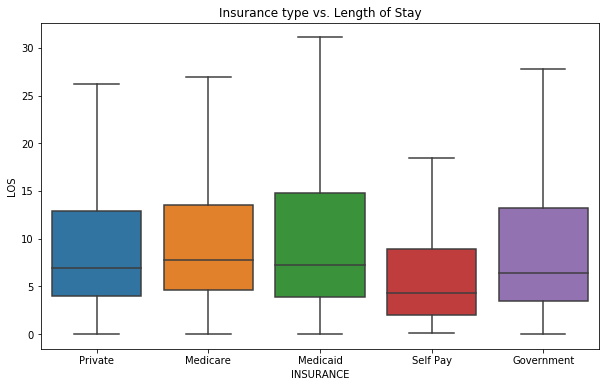

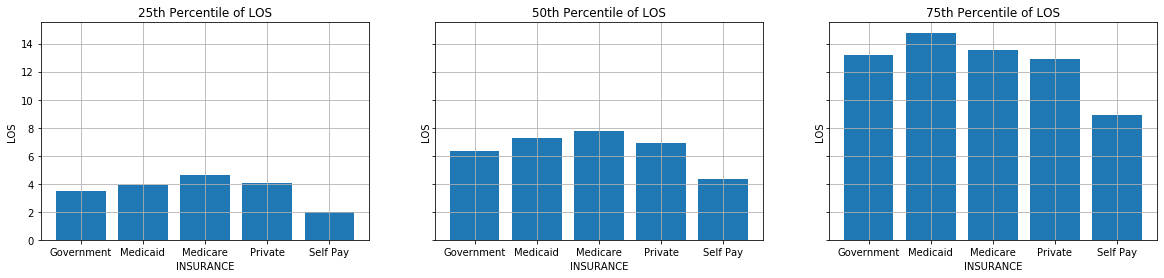

In [8]:
fig, ax = plt.subplots()
ax = sns.boxplot(x='INSURANCE', y='LOS', data=adm_icu_p, showfliers=False)
ax.set_title('Insurance type vs. Length of Stay')
fig.set_size_inches(10, 6, forward=True)
p25 = adm_icu_p.groupby('INSURANCE')['LOS'].quantile(0.25).reset_index(name='25TH_LOS')
p50 = adm_icu_p.groupby('INSURANCE')['LOS'].quantile(0.5).reset_index(name='50TH_LOS')
p75 = adm_icu_p.groupby('INSURANCE')['LOS'].quantile(0.75).reset_index(name='75TH_LOS')
dfcor = p25.merge(p50, on='INSURANCE', how='left')
dfcor = dfcor.merge(p75, on='INSURANCE', how='left')
fig, (ax01, ax02, ax03) = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
ax01.grid()
ax02.grid()
ax03.grid()
ax01.set(xlabel='INSURANCE', ylabel='LOS', title='25th Percentile of LOS')
ax02.set(xlabel='INSURANCE', ylabel='LOS', title='50th Percentile of LOS')
ax03.set(xlabel='INSURANCE', ylabel='LOS', title='75th Percentile of LOS')
ax01.bar(dfcor['INSURANCE'], dfcor['25TH_LOS'])
ax02.bar(dfcor['INSURANCE'], dfcor['50TH_LOS'])
ax03.bar(dfcor['INSURANCE'], dfcor['75TH_LOS']);